# <center>Задание 3</center>

**Задание:**  
Есть А/Б тест направленный на конверсию в покупку (подписки и/или платных фильмов). % что либо купивших в обоих группах одинаковый. Средний чек разный. Каким способом можно проверить, что разница не случайна (с использованием sql и/или python).

**Пояснение к решению:**  
Сформулируем статистическую гипотезу $H_0$: средние чеки в группах *А* и *Б* равны.  
Для этого можно воспользоваться одним из соответствующих статистических критериев.  
  
Самым популярным и достаточно мощным критерием является **t-критерий Стьюдента**, однако он применим только в случае, если выборки следуют нормальным распределениям. Строго говоря, имеющиеся выборки не могут быть распределены нормально, так как являются данными о стоимостях покупок и потому определены на интервале $[0; +\infty)$, в то время как нормальное распределение определено на $(-\infty; +\infty)$.  
Однако, аппроксимация нормальным распределением всё равно может оказаться не столь плохой, так что стоит проверить **гипотезы о нормальности выборок**, для чего можно воспользоваться, например, **критерием Шапиро**. В случае, если гипотезы о нормальности не будут отклонены, можно применить t-критерий (для случая различных дисперсий).  
Далее Следует проверить **гипотезу о равенстве дисперсий**, используя **критерий Фишера**. Если и эта гипотеза не будет отклонена, можно применить t-критерий для случая равных дисперсий или тест ANOVA.  
  
Если же окажется, что выборки нельзя считать нормальными, можно применить критерий Манна-Уитни, однако этот критерий является ранговым, а значит плохо работает, если в выборке много одинаковых значений, что, скорее всего, и будет наблюдаться для покупок фильмов/подписок, так как их стоимости обычно фиксированы. Следовательно, перед применением этого критерия стоит посмотреть на распределение уникальных значений чеков в выборках.  
  
Перед использованием вышеперечисленных критериев данные стоит очистить от выбросов. Выбросами будем считать наблюдения, лежащие за пределами усов боксплота.  
  
В дополнение можно построить P-P plot выборочных функций распределения. В случае, если график будет лежать в большей степени по одну сторону от прямой, проходящей через точки $(0;0)$ и $(1;1)$, можно судить о том, что средние различны.

Предположим, что данные о покупках лежат в нашей базе данных в таблице `AB_test`, которая имеет следующие поля:
* `payment_id` — id покупки (integer)
* `payment` — величина покупки в рублях (float)
* `user_id` — идентификаторы пользователей (integer)
* `test_group` — значение группы ('A' или 'B')

# Импорт нужных библиотек

In [1]:
from sqlalchemy import create_engine
import getpass

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Вытащим из базы данные в pandas Data Frame

Функция для создания подключения

In [2]:
db_name = 'test_db'

def my_engine(db_name):
    print('Please, enter your username:', end=' ')
    username = input()
    password = getpass.getpass('Please, enter your password: ')
    host = 'localhost'
    port = 3306
#     db_name = db_name
    engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{db_name}')
    return engine

In [3]:
eng = my_engine(db_name)

Please, enter your username: root
Please, enter your password: ········


In [4]:
query = f'''

SELECT * FROM {db_name}.AB_test AS c
WHERE c.payment > 0
'''

In [5]:
def load_n_split(engine, query):
    data = pd.read_sql_query(query, eng)
    data_df = pd.DataFrame(data, columns=['payment_id', 
                                          'payment', 
                                          'user_id', 
                                          'test_group'])

    A = data_df.payment[data_df.test_group == 'A'].values
    B = data_df.payment[data_df.test_group == 'B'].values
    
    return A, B, data_df

In [ ]:
A, B, data = load_n_split(eng, query)

___

Так как реальных данных нет, для демонстрации сэмплируем набор данных из бета-распределений с нормальным шумом. В первом случае возьмём симметричное бета распределение (с параметрами 2, 2), во втором с положительной асимметрией (с параметрами 2, 3), что должно немного сместить среднее в меньшую сторону.

In [7]:
A = np.random.beta(2, 2, 50) * 800 + np.random.normal(0, 10, 50)
B = np.random.beta(2, 3, 55) * 800 + np.random.normal(0, 10, 55)

# Посмотрим на некоторые статистики

In [8]:
A.size, B.size

(50, 55)

In [36]:
d = 2

In [35]:
np.mean(A).round(d), np.mean(B).round(d)

(395.03, 323.67)

In [37]:
print(np.min(A).round(d), np.max(A).round(d))
print(np.min(B).round(d), np.max(B).round(d))

49.1 780.59
48.4 679.86


## Выбросим выбросы

Будем считать выбросами всё, что не попадает в интервал $[Q_1 - 1.5\cdot IQR; Q_3 + 1.5\cdot IQR]$, где $Q_1$ и $Q_3$ - верхний и нижний квартили, $IQR = Q_3 - Q_1$

In [11]:
def truncate_outliers(x):
    Q1 = np.quantile(x, 0.25)
    Q3 = np.quantile(x, 0.75)
    IQR = Q3 - Q1
    result = x[(x <= Q3 + 1.5*IQR) & (x >= Q1 - 1.5*IQR)]
    return result

In [12]:
A = truncate_outliers(A)
B = truncate_outliers(B)

In [13]:
A.size, B.size

(50, 55)

In [14]:
def plot_hist(data, name):
    plt.hist(data, bins = 10, density=True)
    plt.title(f'Histogram of {name}')
    plt.xlabel('Payment')
    plt.show

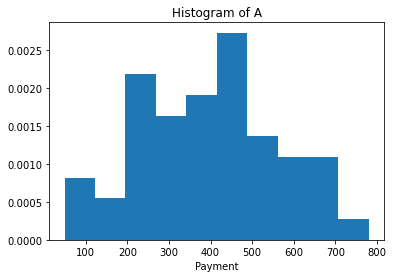

In [15]:
plot_hist(A, 'A')

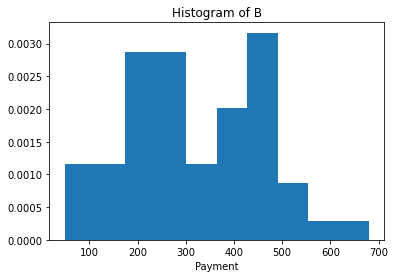

In [16]:
plot_hist(B, 'B')

Визуально далеки от нормальных, хотя данных маловато, чтобы судить. Посмотрим, что скажет тест Шапиро

# Тест на нормальность

In [17]:
stats.shapiro(A)

ShapiroResult(statistic=0.986885666847229, pvalue=0.848646879196167)

In [18]:
stats.shapiro(B)

ShapiroResult(statistic=0.9769120216369629, pvalue=0.36758825182914734)

В обоих случаях статистика незначительно меньше 1 (на уровне значимости 0,05), следовательно отвергнуть гипотезу о том, что данные имеют нормальное распределение, мы не можем.

# Тест Фишера о равенстве дисперсий:

In [38]:
def F_test(x, y):
    F = np.var(x, ddof=1) / np.var(y, ddof=1) # отношение несмещённых оценок дисперсий
    m = x.size - 1 # степени свободы x
    n = y.size - 1 # степени свободы y
    pval = 1 - stats.f.cdf(F, m, n)
    return F.round(5), pval.round(5)

In [39]:
F_test(A, B)

(1.45618, 0.0893)

Как видим, дисперсия в группе А несколько выше по сравнению с В, но это отличие не является значимым на уровне 0,05. Так что можем провести t-тест для случая равных дисперсий и произвести ANOVA

# t-тест

In [21]:
stats.ttest_ind(A, B, equal_var=True)

Ttest_indResult(statistic=2.293808050534564, pvalue=0.023831840214110323)

На всякий случай посчитаем и для неравных дисперсий:

In [22]:
stats.ttest_ind(A, B, equal_var=False)

Ttest_indResult(statistic=2.2734131616473565, pvalue=0.025241537556572043)

В обоих случаях значение статистики значимо отличается от 0, значит и средние между выборками различны

# ANOVA

In [23]:
stats.f_oneway(A, B)

F_onewayResult(statistic=5.261555372697176, pvalue=0.023831840214110434)

Значимо отличается от 1, значит и средние между выборками различны

# Критерий Манна-Уитни

Манна-Уитни тоже посчитаем:

In [24]:
stats.mannwhitneyu(A, B)

MannwhitneyuResult(statistic=1046.0, pvalue=0.017528910134479974)

В реальности значение статистики может быть не таким "хорошим", и в данном случае может быть обусловлено высокой степенью уникальности значений в выборках

# P-P plot

Нужны выборочные функции распределения, получим их с помощью matplotlib  
Фиксируем положения столбцов в диапазоне 40-800, чтобы функции распределения оказались опеределены на одинаковых промежутках

In [28]:
def get_Ps(x):
    x_p, x_q, _ = plt.hist(x, cumulative=True, bins=20, density=True, range=(40, 800))
    return x_p

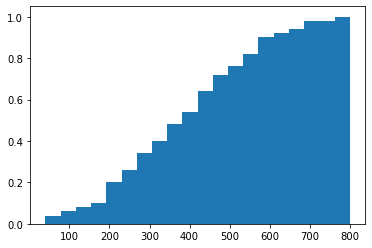

In [29]:
Ap = get_Ps(A)

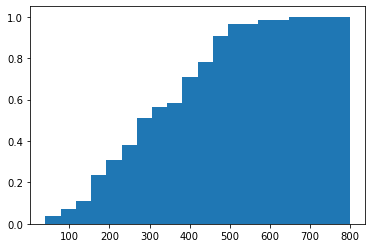

In [30]:
Bp = get_Ps(B)

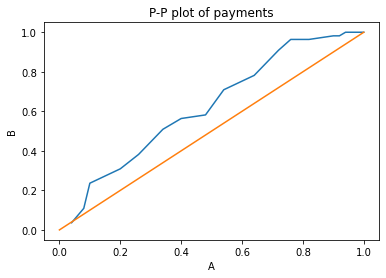

In [32]:
plt.plot(Ap, Bp)
plt.plot([0,1], [0,1])
plt.xlabel('A')
plt.ylabel('B')
plt.title('P-P plot of payments')
plt.show()

P-P plot в целом лежит выше диагонали, а значит в группе B основном чеки на меньшие суммы, чем в группе А